In [1]:
!pip install searchtweets

In [2]:
!pip install textblob

In [3]:
!pip install afinn

In [1]:
import pandas as pd
import numpy as np
import requests
import searchtweets
from textblob import TextBlob
from afinn import Afinn
from datetime import *
import re

In [2]:
df = pd.read_csv("~/work/projetpy/fichiers_csv/tweets_2021-3-1_to_2021-4-1.csv")
#afinn = Afinn()
#afinn_scores = [afinn.score(text) for text in df.text]
#df['afinn'] = afinn_scores
#df[['afinn', 'text']].head()

In [10]:
b = TextBlob("Je suis en colère")
b.detect_language()
b.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [3]:
df.head()

,id,date,screenName,text,type
0,1377376779178967041,2021-03-31 21:46:29,ratonlave57,Pourquoi ne donne t’on pas de l’Aspegic pédiat...,tweet
1,1377339517170933768,2021-03-31 19:18:25,MathildeSlv,@mvrinesv Le syndrome grippal du Pfizer existe...,tweet
2,1377337776819990528,2021-03-31 19:11:30,EBrussat,@montagnethiers #Orleat 210 personnes #vaccine...,tweet
3,1377336854379331584,2021-03-31 19:07:50,garrec_pierre,"En tout cas vendredi, c’est le vaccin astrazen...",tweet
4,1377325612134699012,2021-03-31 18:23:10,FPasquisDumont,1700 centres Pfizer et Moderna...\nPlus de 70 ...,tweet


# Création des métadonnées

Nombre de hashtags

In [4]:
def decompte_hashtags(text):
    exp_match = re.compile("([#]\w+)")
    res = exp_match.findall(text)
    return len(res)

df["nbre_hashtags"] = df["text"].apply(lambda x : decompte_hashtags(x))

Nombre d'url

In [5]:
def decompte_url(text):
    exp_match = re.compile("([https//:]\w+[.]\w+)")
    res = exp_match.findall(text)
    return len(res)

df["nbre_url"] = df["text"].apply(lambda x : decompte_url(x))

Nombre de points d'exclamtion

In [6]:
def decompte_exclamation(text):
    exp_match = re.compile("(\w?\s?[!])")
    res = exp_match.findall(text)
    return len(res)

df["nbre_exclamation"] = df["text"].apply(lambda x : decompte_exclamation(x))


In [7]:
def decompte_suspension(text):
    exp_match = re.compile("(\w?\s?[.]{2,5})")
    res = exp_match.findall(text)
    return 0 if len(res)== 0 else 1
df["presence_suspension"] = df["text"].apply(lambda x : decompte_suspension(x))
df.head()

,id,date,screenName,text,type,nbre_hashtags,nbre_url,nbre_exclamation,presence_suspension
0,1377376779178967041,2021-03-31 21:46:29,ratonlave57,Pourquoi ne donne t’on pas de l’Aspegic pédiat...,tweet,0,0,0,0
1,1377339517170933768,2021-03-31 19:18:25,MathildeSlv,@mvrinesv Le syndrome grippal du Pfizer existe...,tweet,0,0,0,0
2,1377337776819990528,2021-03-31 19:11:30,EBrussat,@montagnethiers #Orleat 210 personnes #vaccine...,tweet,5,0,2,0
3,1377336854379331584,2021-03-31 19:07:50,garrec_pierre,"En tout cas vendredi, c’est le vaccin astrazen...",tweet,0,0,0,0
4,1377325612134699012,2021-03-31 18:23:10,FPasquisDumont,1700 centres Pfizer et Moderna...\nPlus de 70 ...,tweet,0,0,0,1


# Nettoyage des données

In [ ]:
!pip install demoji

In [8]:
# fonction pour la transformation du texte (retrait des caractères spéciaux, des émojis, de la ponctuation, tranformation des majuscules en minuscule, etc)
import demoji
def transforme(texte):
    texte = texte.lower() # mettre les mots en minuscule
    #retirer les liens
    for item in re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+").findall(texte):
        texte=texte.replace(item, "")
    # enlever le retour à la ligne
    texte = texte.replace("\n", " ").replace("\r", "") 
    # supprimer ",", "!", "?", "%", "(",")","/",'"', "$","£", "_", "-", "+", "*", "µ", ":","&,"§" 
    texte = re.sub(r"[,\!\?\%\(\)\/\"\$\£\-\+\*\µ,\:\&\§]", " ", texte) 
    # retirer les hashtags #
    for item in re.compile("([#]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les apostrophes '
    for item in re.compile("([\’])").findall(texte):
        texte=texte.replace(item, " ")
    for item in re.compile("([\'])").findall(texte):
        texte=texte.replace(item, " ")
    # retirer les points de suspension
    for item in re.compile("([.]{1,5})").findall(texte):
        texte=texte.replace(item, "") 
    # retirer les personnes tagées
    for item in re.compile("([@]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les adresses mail
    for item in re.findall('\S+@\S+', texte) :
        texte=texte.replace(item, "")
    # retire les mots contenant des chiffres
    texte = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", texte)
    # retirer les emojis
    for item in demoji.findall(texte):
        texte=texte.replace(item,"")
    return texte
    

In [9]:
pd.options.display.max_colwidth = 1000
df["texte1"]=df["text"].apply(lambda x: transforme(x))
df.tail()

,id,date,screenName,text,type,nbre_hashtags,nbre_url,nbre_exclamation,presence_suspension,texte1
95,1375959954906054659,2021-03-27 23:56:32,Indoartisk5,"@MinisteredelaS1 vaccin première injection d'Astrazeneca ,il faut se faire vacciner massivement mais il faut absolument les doses !! J'encourage toutes les personnes à se faire vacciner car c'est comme cela que l'on s'en sortira 👊🏻💉 💙💙 https://t.co/AbyvSKd2eX",tweet,0,1,2,0,vaccin première injection d astrazeneca il faut se faire vacciner massivement mais il faut absolument les doses j encourage toutes les personnes à se faire vacciner car c est comme cela que l on s en sortira
96,1375917310288990215,2021-03-27 21:07:04,Nadinemarie762,ÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! 👇\nhttps://t.co/ynwKpxq4gS https://t.co/0YIEMCNJfA\nÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! \nhttps://t.co/ynwKpxq4gS,quote,0,3,10,0,ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres
97,1375916974807650306,2021-03-27 21:05:44,Nadinemarie762,ÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! \nhttps://t.co/ynwKpxq4gS,tweet,0,1,5,0,ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres
98,1375916691499155460,2021-03-27 21:04:37,Nadinemarie762,ÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! \nhttps://t.co/ynwKpxq4gS,tweet,0,1,5,0,ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres
99,1375902325244628994,2021-03-27 20:07:32,CaruluP,"Avec ces chiffres là , @EmmanuelMacron va Reconfiner le pays.\n#COVID19 #COVID19france #coronavirus #VaccinationCovid #vaccination #VacunaCOVID19 #Pfizer #Moderna #PfizerVaccine #VaccinoAntiCovid #PfizerBiontech #AstraZeneca https://t.co/fu1AqpI9oP",tweet,12,1,0,0,avec ces chiffres là va reconfiner le pays france vaccine biontech


In [10]:
# Tokenisation en considérant un token comme un mot
#!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
#transformer chaque phrase en liste de mots
df["liste_mots"] = df["texte1"].apply(lambda x: nltk.word_tokenize(x, language ='french'))

In [12]:
df.head()

,id,date,screenName,text,type,nbre_hashtags,nbre_url,nbre_exclamation,presence_suspension,texte1,liste_mots
0,1377376779178967041,2021-03-31 21:46:29,ratonlave57,"Pourquoi ne donne t’on pas de l’Aspegic pédiatrie ,suite à la vaccination par l’astrazeneca pour atténuer le risque de thrombose ?",tweet,0,0,0,0,pourquoi ne donne t on pas de l aspegic pédiatrie suite à la vaccination par l astrazeneca pour atténuer le risque de thrombose,"[pourquoi, ne, donne, t, on, pas, de, l, aspegic, pédiatrie, suite, à, la, vaccination, par, l, astrazeneca, pour, atténuer, le, risque, de, thrombose]"
1,1377339517170933768,2021-03-31 19:18:25,MathildeSlv,@mvrinesv Le syndrome grippal du Pfizer existe aussi au passage askip Astrazeneca like.,tweet,0,0,0,0,le syndrome grippal du pfizer existe aussi au passage askip astrazeneca like,"[le, syndrome, grippal, du, pfizer, existe, aussi, au, passage, askip, astrazeneca, like]"
2,1377337776819990528,2021-03-31 19:11:30,EBrussat,@montagnethiers #Orleat 210 personnes #vaccinees #Moderna depuis lundi ! Merci à nos #soignants les #elus vous accueillent! Encore 2 jours,tweet,5,0,2,0,personnes depuis lundi merci à nos les vous accueillent encore jours,"[personnes, depuis, lundi, merci, à, nos, les, vous, accueillent, encore, jours]"
3,1377336854379331584,2021-03-31 19:07:50,garrec_pierre,"En tout cas vendredi, c’est le vaccin astrazeneca qui s’écoulera dans mes veines 😷",tweet,0,0,0,0,en tout cas vendredi c est le vaccin astrazeneca qui s écoulera dans mes veines,"[en, tout, cas, vendredi, c, est, le, vaccin, astrazeneca, qui, s, écoulera, dans, mes, veines]"
4,1377325612134699012,2021-03-31 18:23:10,FPasquisDumont,"1700 centres Pfizer et Moderna...\nPlus de 70 ans..\nLe 16 avril ...60 et 70..\n...\nA mi-juin pour tous...\n\nFin été tous les Français de + 18 ans vaccinés.. \nMi-mai ouvertures des lieux de culture,de terrasses\nCalendrier de réouverture progressive ...bientôt..",tweet,0,0,0,1,centres pfizer et moderna plus de ans le avril et a mi juin pour tous fin été tous les français de ans vaccinés mi mai ouvertures des lieux de culture de terrasses calendrier de réouverture progressive bientôt,"[centres, pfizer, et, moderna, plus, de, ans, le, avril, et, a, mi, juin, pour, tous, fin, été, tous, les, français, de, ans, vaccinés, mi, mai, ouvertures, des, lieux, de, culture, de, terrasses, calendrier, de, réouverture, progressive, bientôt]"


In [19]:
# Enlever les stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
del df["stopword"]
df["mot_important"] = df["liste_mots"].apply(lambda x: [w for w in x if not w in stop_words])
df.tail()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,date,screenName,text,type,nbre_hashtags,nbre_url,nbre_exclamation,presence_suspension,texte1,liste_mots,score,label,mot_important
95,1375959954906054659,2021-03-27 23:56:32,Indoartisk5,"@MinisteredelaS1 vaccin première injection d'Astrazeneca ,il faut se faire vacciner massivement mais il faut absolument les doses !! J'encourage toutes les personnes à se faire vacciner car c'est comme cela que l'on s'en sortira 👊🏻💉 💙💙 https://t.co/AbyvSKd2eX",tweet,0,1,2,0,vaccin première injection d astrazeneca il faut se faire vacciner massivement mais il faut absolument les doses j encourage toutes les personnes à se faire vacciner car c est comme cela que l on s en sortira,"[vaccin, première, injection, d, astrazeneca, il, faut, se, faire, vacciner, massivement, mais, il, faut, absolument, les, doses, j, encourage, toutes, les, personnes, à, se, faire, vacciner, car, c, est, comme, cela, que, l, on, s, en, sortira]",0.323333,1,"[vaccin, première, injection, astrazeneca, faut, faire, vacciner, massivement, faut, absolument, doses, encourage, toutes, personnes, faire, vacciner, car, comme, cela, sortira]"
96,1375917310288990215,2021-03-27 21:07:04,Nadinemarie762,ÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! 👇\nhttps://t.co/ynwKpxq4gS https://t.co/0YIEMCNJfA\nÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! \nhttps://t.co/ynwKpxq4gS,quote,0,3,10,0,ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres,"[ça, c, est, une, bonne, nouvelle, la, seule, bonne, nouvelle, depuis, des, lustres, ça, c, est, une, bonne, nouvelle, la, seule, bonne, nouvelle, depuis, des, lustres]",0.300000,1,"[ça, bonne, nouvelle, seule, bonne, nouvelle, depuis, lustres, ça, bonne, nouvelle, seule, bonne, nouvelle, depuis, lustres]"
97,1375916974807650306,2021-03-27 21:05:44,Nadinemarie762,ÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! \nhttps://t.co/ynwKpxq4gS,tweet,0,1,5,0,ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres,"[ça, c, est, une, bonne, nouvelle, la, seule, bonne, nouvelle, depuis, des, lustres]",0.300000,1,"[ça, bonne, nouvelle, seule, bonne, nouvelle, depuis, lustres]"
98,1375916691499155460,2021-03-27 21:04:37,Nadinemarie762,ÇA c'est une bonne nouvelle !!!!\nLa SEULE bonne nouvelle depuis des lustres ! \nhttps://t.co/ynwKpxq4gS,tweet,0,1,5,0,ça c est une bonne nouvelle la seule bonne nouvelle depuis des lustres,"[ça, c, est, une, bonne, nouvelle, la, seule, bonne, nouvelle, depuis, des, lustres]",0.300000,1,"[ça, bonne, nouvelle, seule, bonne, nouvelle, depuis, lustres]"
99,1375902325244628994,2021-03-27 20:07:32,CaruluP,"Avec ces chiffres là , @EmmanuelMacron va Reconfiner le pays.\n#COVID19 #COVID19france #coronavirus #VaccinationCovid #vaccination #VacunaCOVID19 #Pfizer #Moderna #PfizerVaccine #VaccinoAntiCovid #PfizerBiontech #AstraZeneca https://t.co/fu1AqpI9oP",tweet,12,1,0,0,avec ces chiffres là va reconfiner le pays france vaccine biontech,"[avec, ces, chiffres, là, va, reconfiner, le, pays, france, vaccine, biontech]",0.000000,0,"[chiffres, là, va, reconfiner, pays, france, vaccine, biontech]"


In [20]:
!pip install wordcloud

     |████████████████████████████████| 363 kB 1.5 MB/s            


In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


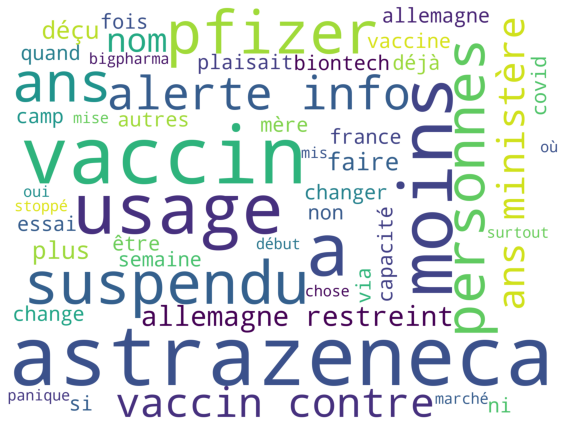

In [28]:
df_cloud = df[df['label']==-1] 
# join tweets to a single string
words = ' '.join(df_cloud['texte1'])

wordcloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2000,
                      height=1500, max_words=50
                     ).generate(words)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


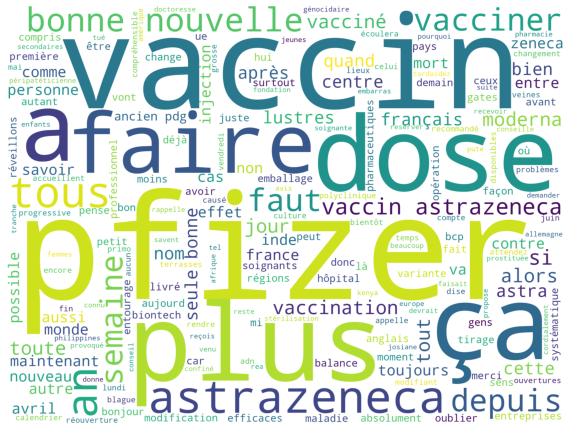

In [26]:
df_cloud = df[df['label']==1] 
# join tweets to a single string
words = ' '.join(df_cloud['texte1'])

wordcloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(words)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Calcul du label à partir de la polarité de textblob (1 pour sentiment positif, 0 pour sentiment neutre et -1 pour sentiment négatif)

In [ ]:
!pip install textblob-fr

In [16]:
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [17]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df["score"]= df["texte1"].apply(lambda x: tb(x).sentiment[0])

In [18]:
df["label"]=df["score"].apply( lambda x: 1 if  x>0 else 0 if x==0 else -1)
df.head()

,id,date,screenName,text,type,nbre_hashtags,nbre_url,nbre_exclamation,presence_suspension,texte1,liste_mots,stopword,score,label
0,1377376779178967041,2021-03-31 21:46:29,ratonlave57,"Pourquoi ne donne t’on pas de l’Aspegic pédiatrie ,suite à la vaccination par l’astrazeneca pour atténuer le risque de thrombose ?",tweet,0,0,0,0,pourquoi ne donne t on pas de l aspegic pédiatrie suite à la vaccination par l astrazeneca pour atténuer le risque de thrombose,"[pourquoi, ne, donne, t, on, pas, de, l, aspegic, pédiatrie, suite, à, la, vaccination, par, l, astrazeneca, pour, atténuer, le, risque, de, thrombose]","[pourquoi, donne, aspegic, pédiatrie, suite, vaccination, astrazeneca, atténuer, risque, thrombose]",0.000,0
1,1377339517170933768,2021-03-31 19:18:25,MathildeSlv,@mvrinesv Le syndrome grippal du Pfizer existe aussi au passage askip Astrazeneca like.,tweet,0,0,0,0,le syndrome grippal du pfizer existe aussi au passage askip astrazeneca like,"[le, syndrome, grippal, du, pfizer, existe, aussi, au, passage, askip, astrazeneca, like]","[syndrome, grippal, pfizer, existe, aussi, passage, askip, astrazeneca, like]",0.000,0
2,1377337776819990528,2021-03-31 19:11:30,EBrussat,@montagnethiers #Orleat 210 personnes #vaccinees #Moderna depuis lundi ! Merci à nos #soignants les #elus vous accueillent! Encore 2 jours,tweet,5,0,2,0,personnes depuis lundi merci à nos les vous accueillent encore jours,"[personnes, depuis, lundi, merci, à, nos, les, vous, accueillent, encore, jours]","[personnes, depuis, lundi, merci, accueillent, encore, jours]",0.300,1
3,1377336854379331584,2021-03-31 19:07:50,garrec_pierre,"En tout cas vendredi, c’est le vaccin astrazeneca qui s’écoulera dans mes veines 😷",tweet,0,0,0,0,en tout cas vendredi c est le vaccin astrazeneca qui s écoulera dans mes veines,"[en, tout, cas, vendredi, c, est, le, vaccin, astrazeneca, qui, s, écoulera, dans, mes, veines]","[tout, cas, vendredi, vaccin, astrazeneca, écoulera, veines]",0.220,1
4,1377325612134699012,2021-03-31 18:23:10,FPasquisDumont,"1700 centres Pfizer et Moderna...\nPlus de 70 ans..\nLe 16 avril ...60 et 70..\n...\nA mi-juin pour tous...\n\nFin été tous les Français de + 18 ans vaccinés.. \nMi-mai ouvertures des lieux de culture,de terrasses\nCalendrier de réouverture progressive ...bientôt..",tweet,0,0,0,1,centres pfizer et moderna plus de ans le avril et a mi juin pour tous fin été tous les français de ans vaccinés mi mai ouvertures des lieux de culture de terrasses calendrier de réouverture progressive bientôt,"[centres, pfizer, et, moderna, plus, de, ans, le, avril, et, a, mi, juin, pour, tous, fin, été, tous, les, français, de, ans, vaccinés, mi, mai, ouvertures, des, lieux, de, culture, de, terrasses, calendrier, de, réouverture, progressive, bientôt]","[centres, pfizer, moderna, plus, ans, avril, a, mi, juin, tous, fin, tous, français, ans, vaccinés, mi, mai, ouvertures, lieux, culture, terrasses, calendrier, réouverture, progressive, bientôt]",0.138,1


In [ ]:
def decompte_hashtags(text):
    exp_match = re.compile("([#]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_hashtags"] = df_tweets["text"].apply(lambda x : decompte_hashtags(x))

In [ ]:
def decompte_tags(text):
    exp_match = re.compile("([@]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_tags"] = df_tweets["text"].apply(lambda x : decompte_tags(x))

In [ ]:
def decompte_mails(text):
    exp_match = re.compile("(\w+[@]\w+[.]\w+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_mails"] = df_tweets["text"].apply(lambda x : decompte_mails(x))

In [ ]:
def decompte_exclamation(text):
    exp_match = re.compile("(\w?\s?[!])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_exclamation"] = df["text"].apply(lambda x : decompte_exclamation(x))

In [ ]:
def decompte_interrogation(text):
    exp_match = re.compile("(\w?\s?[?])")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_interrogation"] = df_tweets["text"].apply(lambda x : decompte_interrogation(x))

In [ ]:
def decompte_mot_maj(text):
    exp_match = re.compile("([A-Z][A-Z]+)")
    res = exp_match.findall(text)
    return len(res)

df_tweets["nbre_maj"] = df_tweets["text"].apply(lambda x : decompte_mot_maj(x))

In [ ]:
df_tweets.head()